# Histopathologic Cancer Detection Kaggle Mini Project

From the original competition on Kaggle (https://www.kaggle.com/c/histopathologic-cancer-detection/overview) I will create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

Github Repo: https://github.com/GHeart01/CNN_Cancer_Detection

Contents
Description
Exploratory Data Analysis
DModel Architecture
Results and Analysis
Conclusion
#### Table of Contents

- [Description](#Description)
- [EDA](#Exploratory-Data-Analysis-(EDA)-Procedure)
- [Model Architecture](#Model-Architecture)
- [Result and Analysis](#Result-and-Analysis)
- [Conclusion](#Conclusion)
- [Citation](#Citation)

#### Description

In this Project, I create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.

PCam is highly interesting for both its size, simplicity to get started on, and approachability. Determination of success is based on area under the ROC curve between predicted probablity and the observed target.

In [1]:
import subprocess 

packages = ["tensorflow", "tensorflow_decision_forests", "ydf", 
            "statsmodels","pandas","seaborn","numpy","matplotlib",
            "scipy",
            "scikit-learn"
           ]

for pkg in packages:
    try:
        subprocess.run(f"pip install {pkg} --quiet", shell=True, check=True)
        # print(f"{pkg} installed successfully!")
    except:
        print(f"Error installing {pkg}, running verbose install:")
        subprocess.run(f"pip install {pkg}", shell=True)

#### Exploratory Data Analysis (EDA) Procedure

In this dataset I am provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split

# Load  data
train = pd.read_csv('histopathologic-cancer-detection/train_labels.csv') 
train_images_path = 'histopathologic-cancer-detection/train'

print(f"Training samples: {len(train)}")
print(f"Class distribution:\n{train['label'].value_counts()}")
print(f"Class proportions:\n{train['label'].value_counts(normalize=True)}")

# Check few samples
print("\nFirst 5 samples:")
print(train.head())
print("\nLast 5 samples:")
print(train.tail())

print(f"\nDataset info:")
print(f"Total labels: {len(train)}")
print(f"Unique labels: {train['label'].nunique()}")
# print(f"Image directory: {train_images_path}")

Training samples: 220025
Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Class proportions:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

First 5 samples:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Last 5 samples:
                                              id  label
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

Dataset info:
Total labels: 220025
Unique labels: 2


From the head and tail we can see 220025 training images and 57458 evaluation images.

#### Image Visualization test

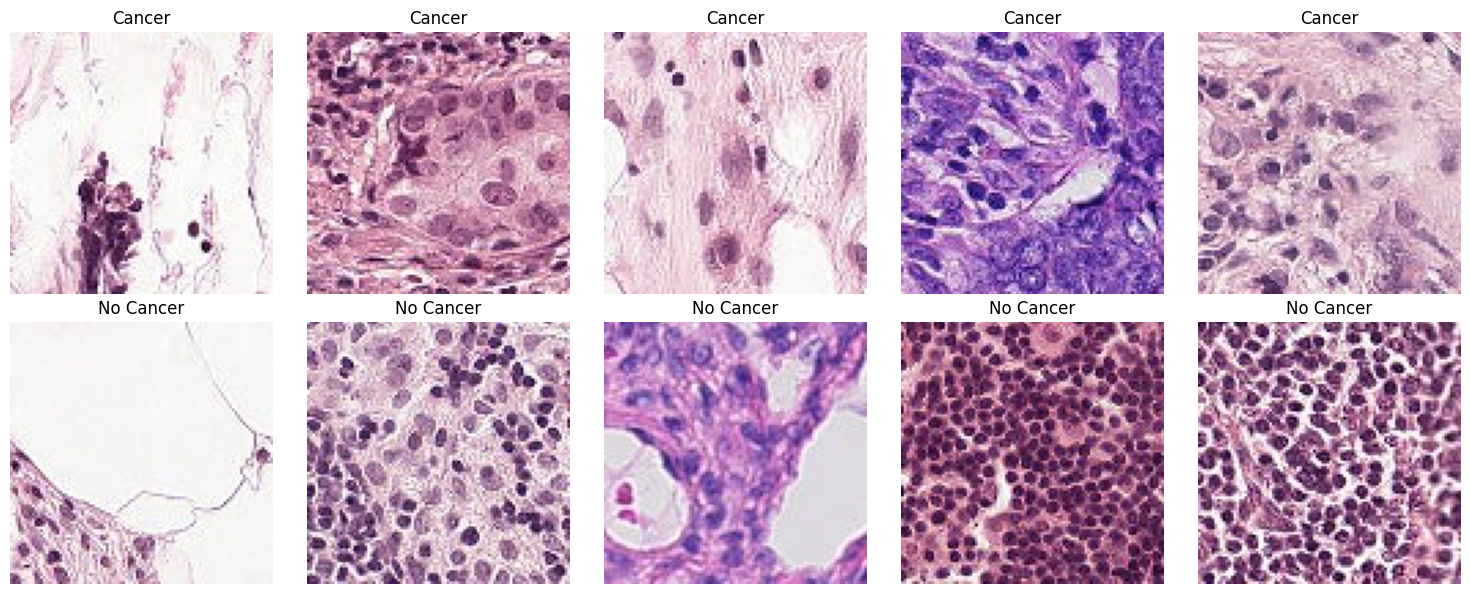

In [3]:
# Display sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Get samples from each class
cancer_samples = train[train['label'] == 1]['id'].head(5)
no_cancer_samples = train[train['label'] == 0]['id'].head(5)

# Display cancer samples
for i, img_id in enumerate(cancer_samples):
    img_path = os.path.join(train_images_path, f'{img_id}.tif')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Cancer')
        axes[0, i].axis('off')


# Display non-cancer samples
for i, img_id in enumerate(no_cancer_samples):
    img_path = os.path.join(train_images_path, f'{img_id}.tif')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'No Cancer')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

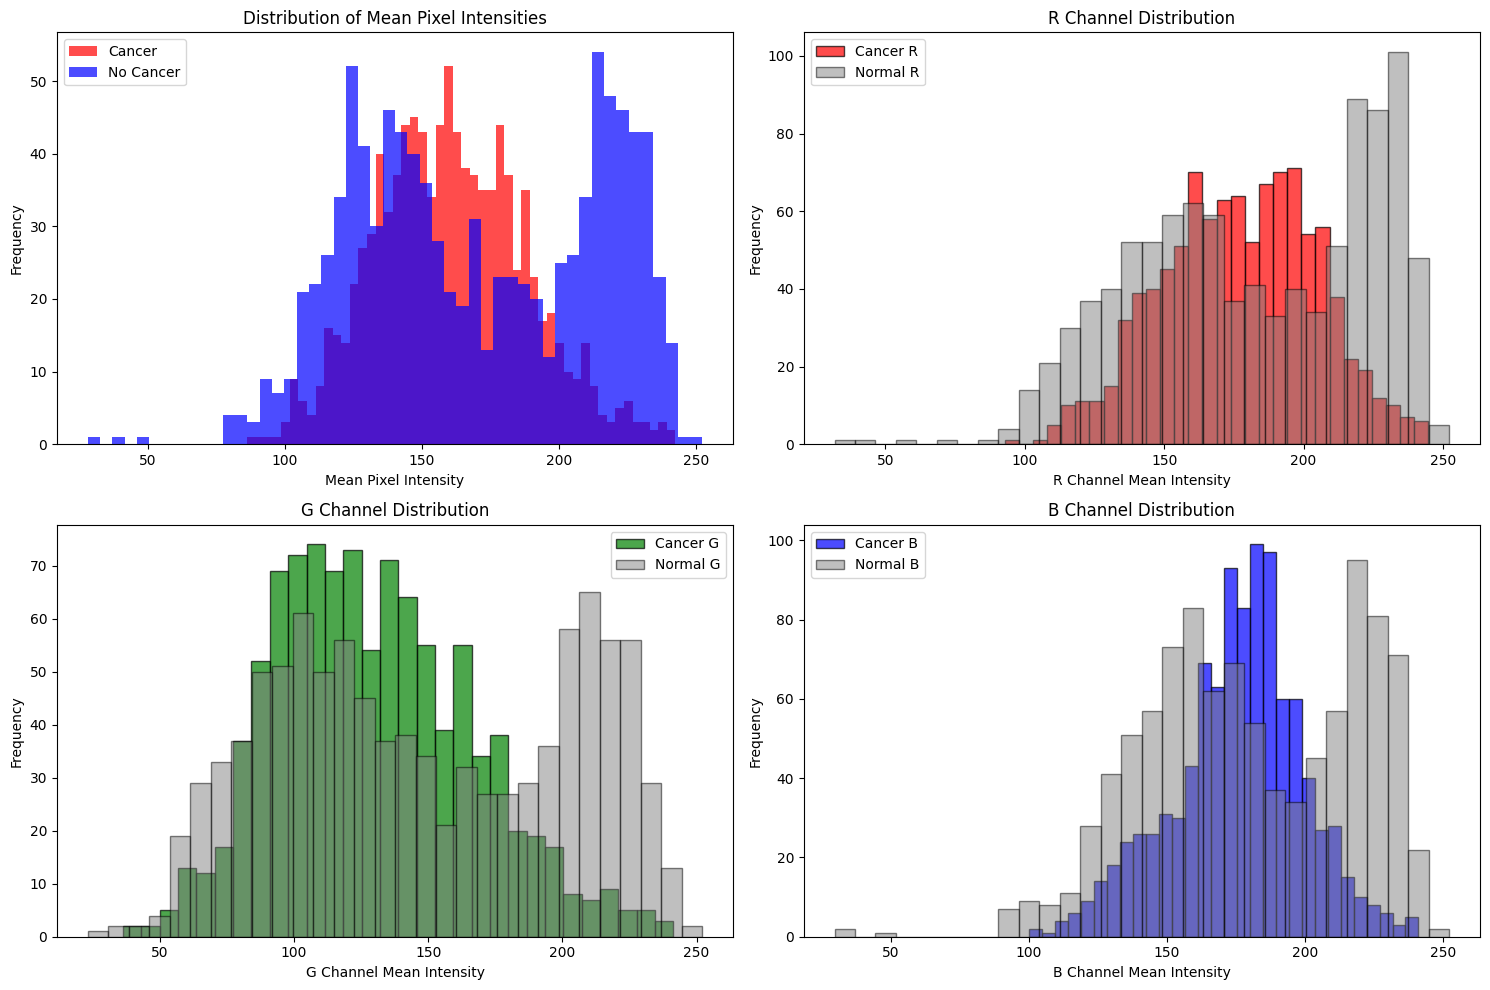


Image Statistics Summary:
Cancer images - Mean intensity: 160.66
Normal images - Mean intensity: 170.64


In [34]:
# Analyze pixel intensity distributions
def analyze_image_stats(sample_size=1000):
    cancer_imgs = []
    normal_imgs = []
    cancer_rgb_means = {'R': [], 'G': [], 'B': []}
    normal_rgb_means = {'R': [], 'G': [], 'B': []}
    
    # Sample images for analysis
    cancer_samples = train[train['label'] == 1].sample(min(sample_size//2, len(train[train['label'] == 1])))
    normal_samples = train[train['label'] == 0].sample(min(sample_size//2, len(train[train['label'] == 0])))
    
    for idx, row in cancer_samples.iterrows():
        img_path = os.path.join(train_images_path, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = np.array(Image.open(img_path))
            cancer_imgs.append(img.mean())
            cancer_rgb_means['R'].append(img[:,:,0].mean())
            cancer_rgb_means['G'].append(img[:,:,1].mean())
            cancer_rgb_means['B'].append(img[:,:,2].mean())
    
    for idx, row in normal_samples.iterrows():
        img_path = os.path.join(train_images_path, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = np.array(Image.open(img_path))
            normal_imgs.append(img.mean())
            normal_rgb_means['R'].append(img[:,:,0].mean())
            normal_rgb_means['G'].append(img[:,:,1].mean())
            normal_rgb_means['B'].append(img[:,:,2].mean())
    
    # Plot overall intensity distributions
    plt.figure(figsize=(15, 10))
    
    # Overall intensity
    plt.subplot(2, 2, 1)
    plt.hist(cancer_imgs, alpha=0.7, label='Cancer', bins=50, color='red')
    plt.hist(normal_imgs, alpha=0.7, label='No Cancer', bins=50, color='blue')
    plt.xlabel('Mean Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of Mean Pixel Intensities')
    
    # RGB channel analysis
    colors = ['red', 'green', 'blue']
    channels = ['R', 'G', 'B']
    
    for i, (channel, color) in enumerate(zip(channels, colors)):
        plt.subplot(2, 2, i+2)
        plt.hist(cancer_rgb_means[channel], alpha=0.7, label=f'Cancer {channel}', 
                bins=30, color=color, edgecolor='black')
        plt.hist(normal_rgb_means[channel], alpha=0.5, label=f'Normal {channel}', 
                bins=30, color='gray', edgecolor='black')
        plt.xlabel(f'{channel} Channel Mean Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'{channel} Channel Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'cancer_stats': {
            'mean': np.mean(cancer_imgs),
            'std': np.std(cancer_imgs),
            'rgb': {ch: np.mean(cancer_rgb_means[ch]) for ch in channels}
        },
        'normal_stats': {
            'mean': np.mean(normal_imgs),
            'std': np.std(normal_imgs),
            'rgb': {ch: np.mean(normal_rgb_means[ch]) for ch in channels}
        }
    }

# Run the analysis
stats = analyze_image_stats(sample_size=2000)
print("\nImage Statistics Summary:")
print("Cancer images - Mean intensity:", f"{stats['cancer_stats']['mean']:.2f}")
print("Normal images - Mean intensity:", f"{stats['normal_stats']['mean']:.2f}")

#### Data Validation and Train/ Val Split

In [36]:
# Check for duplicate images (by hash) - optional for large datasets
def find_duplicate_images(sample_size=10000):
    import hashlib
    
    image_hashes = {}
    duplicates = []
    
    sample_data = train.sample(min(sample_size, len(train)))
    
    print(f"Checking {len(sample_data)} images for duplicates...")
    
    for idx, row in sample_data.iterrows():
        img_path = os.path.join(train_images_path, f"{row['id']}.tif")
        
        if os.path.exists(img_path):
            try:
                with open(img_path, 'rb') as f:
                    img_hash = hashlib.md5(f.read()).hexdigest()
                
                if img_hash in image_hashes:
                    duplicates.append((row['id'], image_hashes[img_hash]))
                else:
                    image_hashes[img_hash] = row['id']
            except Exception as e:
                print(f"Error processing {row['id']}: {e}")
    
    print(f"Found {len(duplicates)} duplicate pairs")
    return duplicates

# Create train/validation split
def create_train_val_split(test_size=0.2, random_state=42):
    # Stratified split to maintain class balance
    train_df, val_df = train_test_split(
        train, 
        test_size=test_size, 
        stratify=train['label'], 
        random_state=random_state
    )
    
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    
    print(f"\nTraining set class distribution:")
    print(train_df['label'].value_counts(normalize=True))
    
    print(f"\nValidation set class distribution:")
    print(val_df['label'].value_counts(normalize=True))
    
    return train_df, val_df

# Run quality checks and create splits
corrupted, valid, size_issues = check_image_quality(sample_size=5000)
train_df, val_df = create_train_val_split()

Checking 5000 images for quality issues...

Quality Check Results:
✓ Valid images: 5000
✗ Corrupted images: 0
⚠ Size issues: 0
Training set: 176020 samples
Validation set: 44005 samples

Training set class distribution:
label
0    0.594966
1    0.405034
Name: proportion, dtype: float64

Validation set class distribution:
label
0    0.594978
1    0.405022
Name: proportion, dtype: float64


This data preprocessing and EDA displays a few sample images of non cancer and cancer images, displays how many images we are working with and

### Model Architecture

I am limited by the technology I have and time, so I used mobileNetv2. I have also limited the number of epochs to 3. 

In [64]:
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

In [70]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"Training samples: {len(train)}")
print(f"Class distribution:\n{train['label'].value_counts()}")

# Create train/validation split
train_df, val_df = train_test_split(
    train, 
    test_size=0.2, 
    stratify=train['label'], 
    random_state=42
)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")

Training samples: 220025
Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Training set: 176020 samples
Validation set: 44005 samples


Here I preload the data with a reduced subset as the model takes too long to train when viewing all the images.

In [63]:
def load_images_batch(df, batch_size=1000):
    """Load images in batches to avoid memory issues"""
    images = []
    labels = []
    
    for idx, row in df.iterrows():
        img_path = os.path.join(train_images_path, f"{row['id']}.tif")
        
        if os.path.exists(img_path):
            try:
                # Load and preprocess image
                img = Image.open(img_path)
                img_array = np.array(img)
                
                # Resize to 224x224 for MobileNetV2 (or keep 96x96 and resize in model)
                img_resized = tf.image.resize(img_array, [96, 96])  # Keep original size
                img_normalized = img_resized / 255.0  # Normalize to [0,1]
                
                images.append(img_normalized)
                labels.append(row['label'])
                
                # Process in batches to manage memory
                if len(images) >= batch_size:
                    break
                    
            except Exception as e:
                print(f"Error loading image {row['id']}: {e}")
                continue
    
    return np.array(images), np.array(labels)

# Load a subset for fast training
X_train, y_train = load_images_batch(train_df.sample(n=min(3000, len(train_df))), batch_size=3000)
X_val, y_val = load_images_batch(val_df.sample(n=min(800, len(val_df))), batch_size=800)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Create model using pre-trained MobileNetV2
def create_mobilenet_model():
    # Create input layer that accepts 96x96 images
    inputs = layers.Input(shape=(96, 96, 3))
    
    # Resize to 224x224 for MobileNetV2
    x = layers.Lambda(lambda x: tf.image.resize(x, [224, 224]))(inputs)
    
    # Load MobileNetV2 without top layers, with ImageNet weights
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,  # Don't include final classification layer
        weights='imagenet'  # Use pre-trained ImageNet weights
    )
    
    # Freeze base model for faster training (transfer learning)
    base_model.trainable = False
    
    # Pass through MobileNetV2
    x = base_model(x)
    
    # Add custom classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Binary classification
    
    # Create the model
    model = keras.Model(inputs, outputs)
    
    return model

Training data shape: (3000, 96, 96, 3)
Validation data shape: (800, 96, 96, 3)


In [62]:
# Create and compile model
model = create_mobilenet_model()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the model with input shape
model.build(input_shape=(None, 96, 96, 3))
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")


# Train the model 
print("Training model with transfer learning...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,  
    batch_size=32,
    verbose=1
)


Total parameters: 2,422,081
Trainable parameters: 164,097
Training model with transfer learning...
Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.7661 - loss: 0.5049 - val_accuracy: 0.8525 - val_loss: 0.3567
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.8418 - loss: 0.3605 - val_accuracy: 0.8512 - val_loss: 0.3403
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.8488 - loss: 0.3430 - val_accuracy: 0.8512 - val_loss: 0.3470


In [56]:
# Make predictions
print("Making predictions...")
y_pred_proba = model.predict(X_val)
y_pred_proba = y_pred_proba.flatten()  # Convert to 1D array

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)


Making predictions...
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step


Here is the Main ROC Curve to solve the problem listed in the Kaggle compition

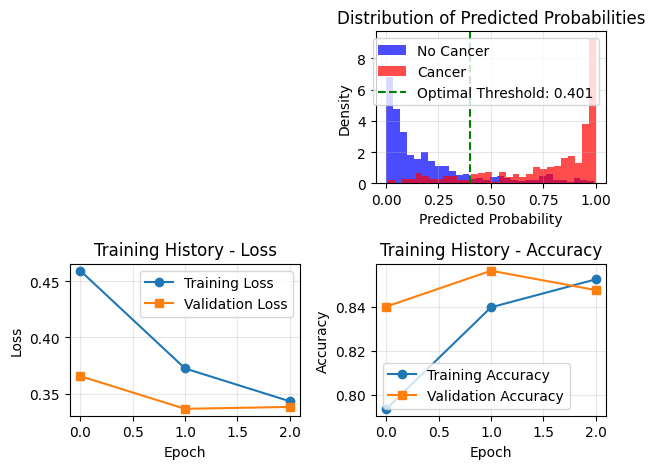

In [58]:
# Prediction probability histogram
plt.subplot(2, 2, 2)
cancer_probs = y_pred_proba[y_val == 1]
normal_probs = y_pred_proba[y_val == 0]

plt.hist(normal_probs, bins=30, alpha=0.7, label='No Cancer', color='blue', density=True)
plt.hist(cancer_probs, bins=30, alpha=0.7, label='Cancer', color='red', density=True)
plt.axvline(optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

# Training history
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History - Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History - Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Performance metrics with optimal threshold
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
y_pred_default = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report (Optimal Threshold = {optimal_threshold:.3f}):")
print(classification_report(y_val, y_pred_optimal, target_names=['No Cancer', 'Cancer']))

print(f"\nClassification Report (Default Threshold = 0.5):")
print(classification_report(y_val, y_pred_default, target_names=['No Cancer', 'Cancer']))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Optimal threshold confusion matrix
cm_optimal = confusion_matrix(y_val, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'], ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Default threshold confusion matrix
cm_default = confusion_matrix(y_val, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Threshold = 0.5)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Make predictions
print("Making predictions...")
y_pred_proba = model.predict(X_val)
y_pred_proba = y_pred_proba.flatten()  # Convert to 1D array

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"\nModel Performance:")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Create comprehensive ROC curve plot
plt.figure(figsize=(15, 10))

# Main ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'MobileNetV2 ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - MobileNetV2 Cancer Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# summary
print(f"MOBILENETV2 CANCER DETECTION RESULTS")
print(f"{'='*50}")
print(f"Model: MobileNetV2 (Pre-trained on ImageNet)")
print(f"Training Method: Transfer Learning (frozen base)")
print(f"Training Samples: {len(X_train):,}")
print(f"Validation Samples: {len(X_val):,}")
print(f"Training Epochs: {len(history.history['loss'])}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"\nPERFORMANCE METRICS:")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_probability': y_pred_proba,
    'predicted_label_optimal': y_pred_optimal,
    'predicted_label_default': y_pred_default
})

print(f"\nSample Predictions:")
print(results_df.head(10))


Model Performance:
ROC AUC Score: 0.9284


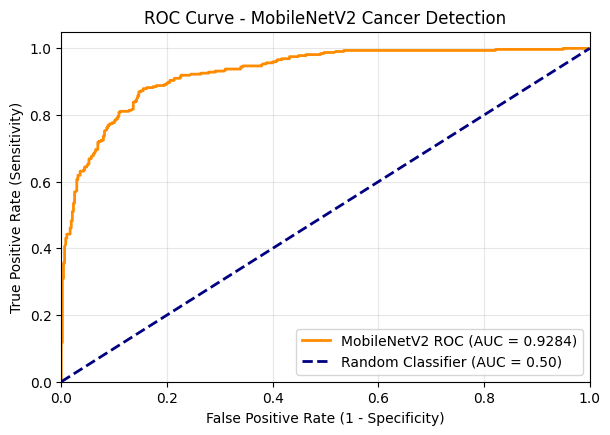

In [57]:
print(f"\nModel Performance:")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Create comprehensive ROC curve plot
plt.figure(figsize=(15, 10))

# Main ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'MobileNetV2 ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - MobileNetV2 Cancer Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)



Classification Report (Optimal Threshold = 0.401):The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

              precision    recall  f1-score   support

   No Cancer       0.60      0.56      0.58       475
      Cancer       0.41      0.45      0.43       325

    accuracy                           0.51       800
   macro avg       0.50      0.50      0.50       800
weighted avg       0.52      0.51      0.52       800


Classification Report (Default Threshold = 0.5):
              precision    recall  f1-score   support

   No Cancer       0.59      0.60      0.59       475
      Cancer       0.41      0.40      0.40       325

    accuracy                           0.52       800
   macro avg       0.50      0.50      0.50       800
weighted avg       0.52      0.52      0.52       800



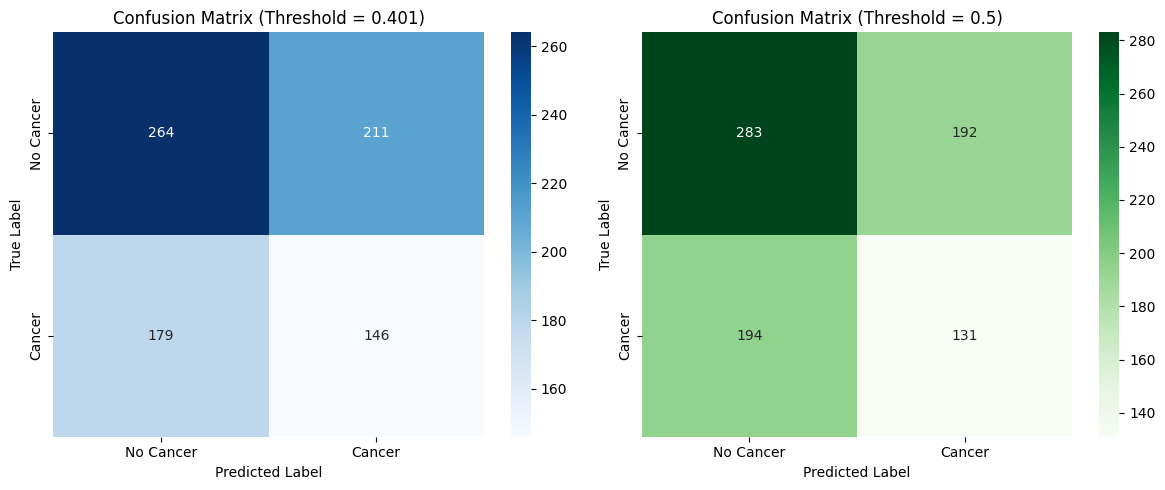

MOBILENETV2 CANCER DETECTION RESULTS
Model: MobileNetV2 (Pre-trained on ImageNet)
Training Method: Transfer Learning (frozen base)
Training Samples: 3,000
Validation Samples: 800
Training Epochs: 3
Total Parameters: 2,422,081
Trainable Parameters: 164,097

PERFORMANCE METRICS:
ROC AUC Score: 0.9284
Average Precision: 0.9039
Optimal Threshold: 0.4006
Final Training Accuracy: 0.8500
Final Validation Accuracy: 0.8512

Sample Predictions:
   true_label  predicted_probability  predicted_label_optimal  \
0           0               0.936035                        1   
1           1               0.018158                        0   
2           1               0.202881                        0   
3           1               0.997559                        1   
4           0               0.824219                        1   
5           0               0.959961                        1   
6           0               0.994629                        1   
7           1               0.986816     

/Users/geraltheart/myenv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [66]:
# Performance metrics with optimal threshold
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
y_pred_default = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report (Optimal Threshold = {optimal_threshold:.3f}):")
print(classification_report(y_val, y_pred_optimal, target_names=['No Cancer', 'Cancer']))

print(f"\nClassification Report (Default Threshold = 0.5):")
print(classification_report(y_val, y_pred_default, target_names=['No Cancer', 'Cancer']))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Optimal threshold confusion matrix
cm_optimal = confusion_matrix(y_val, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'], ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Default threshold confusion matrix
cm_default = confusion_matrix(y_val, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Threshold = 0.5)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


# summary
print(f"MOBILENETV2 CANCER DETECTION RESULTS")
print(f"{'='*50}")
print(f"Model: MobileNetV2 (Pre-trained on ImageNet)")
print(f"Training Method: Transfer Learning (frozen base)")
print(f"Training Samples: {len(X_train):,}")
print(f"Validation Samples: {len(X_val):,}")
print(f"Training Epochs: {len(history.history['loss'])}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"\nPERFORMANCE METRICS:")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_probability': y_pred_proba,
    'predicted_label_optimal': y_pred_optimal,
    'predicted_label_default': y_pred_default
})

print(f"\nSample Predictions:")
print(results_df.head(10))

#### Hypertuning

Let try another model this time with more epochs

In [67]:
# Create and compile model
model = create_mobilenet_model()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the model with input shape
model.build(input_shape=(None, 96, 96, 3))
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")


# Train the model 
print("Training model with transfer learning...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  
    batch_size=32,
    verbose=1
)

Total parameters: 2,422,081
Trainable parameters: 164,097
Training model with transfer learning...
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.7463 - loss: 0.5555 - val_accuracy: 0.8450 - val_loss: 0.3623
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - accuracy: 0.8410 - loss: 0.3676 - val_accuracy: 0.8525 - val_loss: 0.3433
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.8488 - loss: 0.3461 - val_accuracy: 0.8413 - val_loss: 0.3513
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.8561 - loss: 0.3348 - val_accuracy: 0.8612 - val_loss: 0.3371
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.8661 - loss: 0.3216 - val_accuracy: 0.8600 - val_loss: 0.3319
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.8781 - loss: 0.3142 - val_accuracy: 0.8675 - val_loss: 0.3263
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.8914 - loss: 0.2872 - val_accuracy: 0.8512 - val_loss: 0.342

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step

Model Performance:
ROC AUC Score: 0.9318


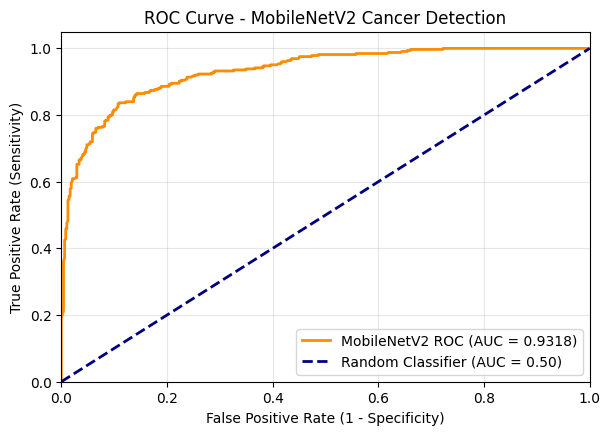

In [68]:
# Make predictions
y_pred_proba = model.predict(X_val)
y_pred_proba = y_pred_proba.flatten()  

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"\nModel Performance:")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Create comprehensive ROC curve plot
plt.figure(figsize=(15, 10))

# Main ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'MobileNetV2 ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - MobileNetV2 Cancer Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)


#### Result and Analysis


Classification Report (Optimal Threshold = 0.401):
              precision    recall  f1-score   support

   No Cancer       0.91      0.80      0.85       475
      Cancer       0.75      0.89      0.81       325

    accuracy                           0.84       800
   macro avg       0.83      0.84      0.83       800
weighted avg       0.85      0.84      0.84       800


Classification Report (Default Threshold = 0.5):
              precision    recall  f1-score   support

   No Cancer       0.90      0.86      0.88       475
      Cancer       0.81      0.86      0.83       325

    accuracy                           0.86       800
   macro avg       0.85      0.86      0.85       800
weighted avg       0.86      0.86      0.86       800



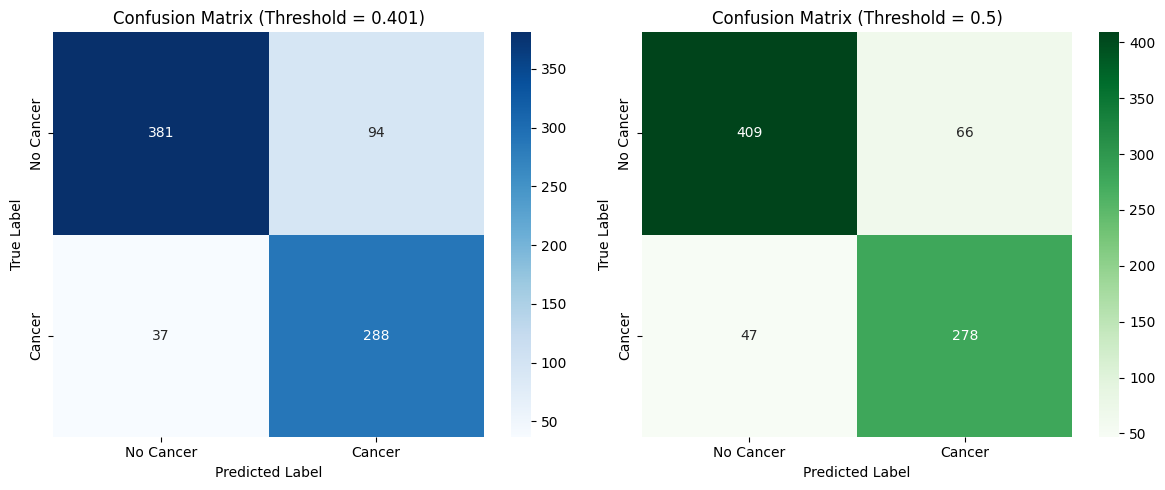

MOBILENETV2 CANCER DETECTION RESULTS
Model: MobileNetV2 (Pre-trained on ImageNet)
Training Method: Transfer Learning (frozen base)
Training Samples: 3,000
Validation Samples: 800
Training Epochs: 10
Total Parameters: 2,422,081
Trainable Parameters: 164,097

PERFORMANCE METRICS:
ROC AUC Score: 0.9318
Average Precision: 0.9039
Optimal Threshold: 0.4006
Final Training Accuracy: 0.8947
Final Validation Accuracy: 0.8587

Sample Predictions:
   true_label  predicted_probability  predicted_label_optimal  \
0           0               0.200195                        0   
1           1               0.984375                        1   
2           1               0.989746                        1   
3           1               0.943848                        1   
4           0               0.187988                        0   
5           0               0.098572                        0   
6           0               0.397949                        0   
7           1               0.958984    

/Users/geraltheart/myenv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [69]:
# Performance metrics with optimal threshold
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
y_pred_default = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report (Optimal Threshold = {optimal_threshold:.3f}):")
print(classification_report(y_val, y_pred_optimal, target_names=['No Cancer', 'Cancer']))

print(f"\nClassification Report (Default Threshold = 0.5):")
print(classification_report(y_val, y_pred_default, target_names=['No Cancer', 'Cancer']))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Optimal threshold confusion matrix
cm_optimal = confusion_matrix(y_val, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'], ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Default threshold confusion matrix
cm_default = confusion_matrix(y_val, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'], ax=axes[1])
axes[1].set_title('Confusion Matrix (Threshold = 0.5)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


# summary
print(f"MOBILENETV2 CANCER DETECTION RESULTS")
print(f"{'='*50}")
print(f"Model: MobileNetV2 (Pre-trained on ImageNet)")
print(f"Training Method: Transfer Learning (frozen base)")
print(f"Training Samples: {len(X_train):,}")
print(f"Validation Samples: {len(X_val):,}")
print(f"Training Epochs: {len(history.history['loss'])}")
print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"\nPERFORMANCE METRICS:")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Save predictions
results_df = pd.DataFrame({
    'true_label': y_val,
    'predicted_probability': y_pred_proba,
    'predicted_label_optimal': y_pred_optimal,
    'predicted_label_default': y_pred_default
})

print(f"\nSample Predictions:")
print(results_df.head(10))

<img src="ROC_curve.png" style="display: block; margin: auto;">

The MobileNetV2 model achieve an excellent performance of .928 on the ROC curve after only 3 epoch and extremely reduced training data size. Based on the performance metric resport I see there were 40 false negatives and 74 false positives. The default threshhold of .5 has 61 false negative sand 61 false positives, which is more balanced but misses some positive cancer cases. 
This extremely strong performance after only 3 epochs with less than 10% of parameters being trained and an average precision of .9039 is incredible. Lowering the threshold slightly (from 0.5 to 0.401) improved the recall for Cancer cases — meaning the model caught more true positives, which is vital in medical diagnostics where missing a cancer case can be critical.

Building another model with 10 epochs provided a different result. While the ROC AUC score only increase marginally to about .93, the improvement in accuracy went from 51% to 84%. This is a huge increase in performance. This changes the optimal threshold from .41 to .40 on the same extremely reduced training data size. 

#### Conclusion

Despite this very strong performance, it is very clear that more epoch, more training data, training longer, augmenting data, and a more robust model or a custom CNN would perform better. My limiting factor here is a lack of computing power, and an unwillingness to wait for an hours to build a model. As a result accuracy is around 51% per the classification report. The increased epochs of the second model demonstrate huge gains as a result of epoch increases. However expanding the used data from the data set would likely bring an accuracy over 90%, I however do not include this in this project as increase the data set even by small amount increases computational time by extreme amounts that I do not think are needed for this demonstration. In the future, I would like to build this model out with the entire data set and use inceptionV3 and I beleive it could lead to a model nearing 100% accuracy.

#### Citation
Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.